# Playsense-id  model training

## 1.Basic analysis 

### 1.1  raw data 

In [3]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

# Define the data folder and file path
data_folder = "../data/"
data_file = "controller_data_user1_20250307_112616.csv"
file_path = os.path.join(data_folder, data_file)

# Check if the file exists before reading
if os.path.exists(file_path):
    # Read the CSV file into a pandas DataFrame
    df = pd.read_csv(file_path)
    
    # Display the first few rows of the DataFrame
    print("First 5 rows of the dataset:")
    display(df.head())
    
    # Count the values of the button_press column
    print("\nButton press counts:")
    display(df['button_press'].value_counts())
    
    # Display summary statistics
    print("\nSummary statistics:")
    display(df.describe())
    
    # Display information about the DataFrame
    print("\nDataFrame information:")
    df.info()
else:
    print(f"Error: File not found at {file_path}")
    print("Please check if the file exists or if the path is correct.")



First 5 rows of the dataset:


,timestamp,button_press,gyro_pitch,gyro_yaw,gyro_roll,acc_x,acc_y,acc_z,user_id
0,2025-03-07T11:26:16.592564,none,0,0,0,0,0,0,user1
1,2025-03-07T11:26:16.597643,none,-491,8288,-1140,-55,-63,60,user1
2,2025-03-07T11:26:16.602667,none,-464,8259,-1143,-46,-63,64,user1
3,2025-03-07T11:26:16.606753,none,-449,8260,-1103,-36,-61,69,user1
4,2025-03-07T11:26:16.611815,none,-459,8284,-1092,-27,-60,71,user1



Button press counts:


button_press
none      5605
up         139
left        78
right       62
down        59
square      52
cross       32
circle      24
Name: count, dtype: int64


Summary statistics:


,gyro_pitch,gyro_yaw,gyro_roll,acc_x,acc_y,acc_z
count,6051.000000,6051.000000,6051.000000,6051.000000,6051.000000,6051.000000
mean,-236.425549,7955.655098,-1503.924475,27.447695,-5.453314,36.862502
std,1066.765135,359.150505,1111.600017,401.740601,325.274700,395.302357
min,-2716.000000,0.000000,-4226.000000,-1731.000000,-2019.000000,-2308.000000
25%,-776.000000,7897.000000,-2084.500000,-25.000000,-14.000000,-17.000000
50%,-590.000000,7994.000000,-1911.000000,2.000000,5.000000,9.000000
75%,-179.000000,8147.000000,-986.000000,35.000000,30.000000,45.000000
max,3919.000000,9395.000000,3920.000000,2089.000000,1272.000000,2163.000000



DataFrame information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6051 entries, 0 to 6050
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   timestamp     6051 non-null   object
 1   button_press  6051 non-null   object
 2   gyro_pitch    6051 non-null   int64 
 3   gyro_yaw      6051 non-null   int64 
 4   gyro_roll     6051 non-null   int64 
 5   acc_x         6051 non-null   int64 
 6   acc_y         6051 non-null   int64 
 7   acc_z         6051 non-null   int64 
 8   user_id       6051 non-null   object
dtypes: int64(6), object(3)
memory usage: 425.6+ KB


In [27]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from datetime import datetime
from matplotlib.ticker import MaxNLocator


# ========= functions for the anlaysis the raw df =====================
def preprocess_data(df):
    """Preprocess the input DataFrame."""
    if df['timestamp'].dtype == 'object':
        df['timestamp'] = pd.to_datetime(df['timestamp'])
    df_analysis = df.copy()
    return df_analysis

def extract_button_events(df_analysis):
    """Extract relevant button events and transitions."""
    button_events = df_analysis[~df_analysis['button_press'].str.contains('EVENT:', na=False)].copy()
    button_events['prev_button'] = button_events['button_press'].shift(1)
    button_events['is_transition'] = button_events['button_press'] != button_events['prev_button']
    button_events['press_start'] = (button_events['prev_button'] == 'none') & (button_events['button_press'] != 'none')
    button_events['press_end'] = (button_events['prev_button'] != 'none') & (button_events['button_press'] == 'none')
    return button_events

def detect_buttons(button_events):
    """Detect all unique buttons in the dataset."""
    all_buttons = set()
    for buttons in button_events['button_press'].unique():
        if isinstance(buttons, str) and buttons != 'none' and not buttons.startswith('EVENT:'):
            all_buttons.update(buttons.split(','))
    return all_buttons

def compute_button_statistics(button_events, all_buttons):
    """Compute statistics for each button."""
    press_starts = button_events[button_events['press_start']].copy()
    button_stats = {}
    for button in all_buttons:
        count = sum(press_starts['button_press'].str.contains(button, na=False))
        button_presses = button_events[button_events['button_press'].str.contains(button, na=False)].copy()
        if not button_presses.empty:
            button_presses.loc[:, 'group'] = button_presses['is_transition'].cumsum()
            grouped = button_presses.groupby('group')
            avg_sequence = grouped.size().mean()
            last_press = button_presses['timestamp'].max()
            sequences = [(group['timestamp'].max() - group['timestamp'].min()).total_seconds() * 1000 
                         for _, group in grouped if len(group) > 1]
            avg_duration = np.mean(sequences) if sequences else np.nan
            button_stats[button] = {
                'count': count,
                'avg_sequence_length': avg_sequence,
                'avg_duration_ms': avg_duration,
                'last_press': last_press
            }
    return pd.DataFrame.from_dict(button_stats, orient='index').reset_index().rename(columns={'index': 'button'}).sort_values('count', ascending=False)

def plot_button_statistics(stats_df, button_events, all_buttons):
    """Generate visualizations of button statistics."""
    plt.figure(figsize=(14, 10))
    
    # Create data for boxplots
    button_records = {}
    button_durations = {}
    
    for button in all_buttons:
        button_presses = button_events[button_events['button_press'].str.contains(button, na=False)].copy()
        if not button_presses.empty:
            button_presses.loc[:, 'group'] = button_presses['is_transition'].cumsum()
            grouped = button_presses.groupby('group')
            
            # Collect records count for each press event
            records_counts = grouped.size().values
            button_records[button] = records_counts
            
            # Collect duration for each press event
            durations = [(group['timestamp'].max() - group['timestamp'].min()).total_seconds() * 1000 
                         for _, group in grouped if len(group) > 1]
            if durations:
                button_durations[button] = durations
    
    # Plot records count boxplot
    plt.subplot(2, 2, 1)
    plt.boxplot([button_records[button] for button in all_buttons], tick_labels=all_buttons)
    plt.title('Distribution of Records Count per Button Press')
    plt.ylabel('Number of Records')
    plt.xticks(rotation=45)
    
    # Plot duration boxplot
    plt.subplot(2, 2, 2)
    valid_buttons = [button for button in all_buttons if button in button_durations and button_durations[button]]
    if valid_buttons:
        plt.boxplot([button_durations[button] for button in valid_buttons], tick_labels=valid_buttons)
        plt.title('Distribution of Press Duration per Button')
        plt.ylabel('Duration (ms)')
        plt.xticks(rotation=45)
    else:
        plt.text(0.5, 0.5, 'No valid duration data available', ha='center', va='center')
    
    # Plot sequence events timeline
    plt.subplot(2, 1, 2)
    press_events = button_events[button_events['button_press'] != 'none'].copy()
    if not press_events.empty:
        # Get the time range
        min_time = press_events['timestamp'].min()
        max_time = press_events['timestamp'].max()
        
        # Create a dictionary to store button positions on y-axis
        button_positions = {button: i for i, button in enumerate(all_buttons)}
        
        # Plot each button press as a vertical line
        for button in all_buttons:
            button_data = press_events[press_events['button_press'].str.contains(button, na=False)]
            if not button_data.empty:
                # Convert timestamps to seconds from start
                times = [(t - min_time).total_seconds() for t in button_data['timestamp']]
                # Plot vertical lines for each press
                for t in times:
                    plt.plot([t, t], [button_positions[button]-0.2, button_positions[button]+0.2], 'k-', linewidth=1.5)
        
        plt.yticks(list(button_positions.values()), list(button_positions.keys()))
        plt.xlabel('Time (seconds from start)')
        plt.title('Button Press Events Timeline')
        plt.xlim(0, (max_time - min_time).total_seconds())
    else:
        plt.text(0.5, 0.5, 'No button press events available', ha='center', va='center')
    
    plt.tight_layout()
    plt.show()

def analyze_button_sequences(button_events):
    """Analyze temporal patterns between button presses. For example A->B , B->C as pattern"""
    sequences = button_events[button_events['button_press'] != 'none'].copy()
    sequences.loc[:, 'time_diff'] = (sequences['timestamp'] - sequences['timestamp'].shift(1)).dt.total_seconds() * 1000
    sequences = sequences[~sequences['prev_button'].isna()]
    common_sequences = []
    for i in range(len(sequences) - 1):
        if sequences.iloc[i]['is_transition'] and sequences.iloc[i+1]['is_transition']:
            btn1, btn2 = sequences.iloc[i]['button_press'], sequences.iloc[i+1]['button_press']
            time_diff = sequences.iloc[i+1]['time_diff']
            if not pd.isna(time_diff) and btn1 != 'none' and btn2 != 'none':
                common_sequences.append((btn1, btn2, time_diff))
    if common_sequences:
        seq_df = pd.DataFrame(common_sequences, columns=['first_button', 'second_button', 'time_diff_ms'])
        sequence_counts = seq_df.groupby(['first_button', 'second_button']).size().reset_index(name='count').sort_values('count', ascending=False).head(10)
        timing_stats = seq_df.groupby(['first_button', 'second_button'])['time_diff_ms'].agg(['mean', 'std', 'min', 'max']).reset_index().sort_values('mean')
        return sequence_counts, timing_stats
    return None, None


def find_button_press_intervals(df_analysis):
    """Finds all press and non-press intervals in button press data."""

    # Ensure data is sorted by timestamp
    df_analysis = df_analysis.sort_values(by='timestamp').reset_index(drop=True)

    # Compute time difference between consecutive rows in milliseconds
    df_analysis['time_diff'] = df_analysis['timestamp'].diff().dt.total_seconds() * 1000  # ms

    # Create group identifiers for sequences of same type (press or none)
    df_analysis['group'] = (df_analysis['button_press'] != df_analysis['button_press'].shift()).cumsum()

    # Group sequences and calculate duration
    grouped = df_analysis.groupby('group').agg(
        press_type=('button_press', 'first'),
        start_time=('timestamp', 'first'),
        end_time=('timestamp', 'last')
    )

    grouped['duration'] = (grouped['end_time'] - grouped['start_time']).dt.total_seconds() * 1000  # ms

    # Extracting press and non-press intervals
    non_press_intervals= grouped[grouped['press_type'] != 'none']['duration'] # not none means the press duration, non-press interval
    press_intervals = grouped[grouped['press_type'] == 'none']['duration'] # none means the press interval, non-press duration 

    # Plotting the distributions
    plt.figure(figsize=(14, 10))

    # Plot press intervals
    plt.subplot(2, 2, 1)
    sns.histplot(press_intervals, kde=True, color='blue', bins=30)
    plt.title('Distribution of Button Press Intervals')
    plt.xlabel('Time Interval (ms)')
    plt.ylabel('Frequency')

    # Plot non-press intervals
    plt.subplot(2, 2, 2)
    sns.histplot(non_press_intervals, kde=True, color='red', bins=30)
    plt.title('Distribution of Non-Press Intervals/Button press duration')
    plt.xlabel('Time Interval (ms)')
    plt.ylabel('Frequency')

    # Plot non-press sequence lengths (number of consecutive "none")
    plt.subplot(2, 2, 3)
    non_press_lengths = (df_analysis['button_press'] == 'none').astype(int).groupby(df_analysis['group']).sum()
    non_press_lengths = non_press_lengths[non_press_lengths > 0]  # Remove zeros

    if not non_press_lengths.empty:
        ax = sns.histplot(non_press_lengths, kde=True, color='green', bins=30)
        plt.title('Distribution of Non-Press Sequence Lengths')
        plt.xlabel('Number of Consecutive Non-Press Records')
        plt.ylabel('Frequency')

        # Add labels to bars
        for p in ax.patches:
            x = p.get_x() + p.get_width() / 2
            y = p.get_height()
            if y > 0.5:  # Only label bars with height > 0.5
                ax.annotate(f'{int(x)}', (x, y), ha='center', va='bottom', fontsize=8)
    else:
        plt.text(0.5, 0.5, 'No non-press sequences found', horizontalalignment='center', verticalalignment='center')

    plt.tight_layout()
    plt.show()

    return press_intervals, non_press_intervals

# ==============functions for the raws ====================



# main function call to anlysis the df data to know the infor of the press button events 
def analyze_button_presses_with_intervals(df):
    """Function to execute button press analysis along with interval analysis."""
    df_analysis = preprocess_data(df)
    button_events = extract_button_events(df_analysis)
    all_buttons = detect_buttons(button_events)
    print(f"Detected buttons: {', '.join(sorted(all_buttons))}")
    
    # Compute statistics and visualize button press events
    stats_df = compute_button_statistics(button_events, all_buttons)
    display(stats_df)
    plot_button_statistics(stats_df, button_events, all_buttons)
    
    # Analyze and visualize button press and non-press intervals
    press_intervals, non_press_intervals = find_button_press_intervals(df_analysis)

    # Optional: Print interval statistics (mean, std, etc.)
    print(f"\nPress Intervals: Mean = {press_intervals.mean():.2f} ms, Std = {press_intervals.std():.2f} ms")
    print(f"Non-Press Intervals: Mean = {non_press_intervals.mean():.2f} ms, Std = {non_press_intervals.std():.2f} ms")
    
    # Analyze button sequences
    sequence_counts, timing_stats = analyze_button_sequences(button_events)
    if sequence_counts is not None:
        print("\nTop 10 Most Common Button Sequences:")
        display(sequence_counts)
        print("\nTiming Between Button Sequences (ms):")
        display(timing_stats)
    else:
        print("No button sequences detected in the data.")
    
    if not stats_df.empty:
        most_pressed = stats_df.iloc[0]
        print(f"\nMost pressed button: {most_pressed['button']} ({most_pressed['count']} times)")
        valid_durations = stats_df.dropna(subset=['avg_duration_ms'])
        if not valid_durations.empty:
            longest_press = valid_durations.iloc[valid_durations['avg_duration_ms'].idxmax()]
            print(f"Button with longest average press: {longest_press['button']} ({longest_press['avg_duration_ms']:.2f} ms)")

Detected buttons: circle, cross, down, left, right, square, up


,button,count,avg_sequence_length,avg_duration_ms,last_press
4,up,4,34.75,168.396,2025-03-07 11:26:43.644303
1,right,2,31.00,149.826,2025-03-07 11:26:43.127398
0,square,2,26.00,124.262,2025-03-07 11:26:39.552093
6,down,2,29.50,141.712,2025-03-07 11:26:42.421261
5,left,2,39.00,188.871,2025-03-07 11:26:41.847694
2,cross,1,32.00,155.041,2025-03-07 11:26:39.999734
3,circle,1,24.00,114.504,2025-03-07 11:26:40.497528


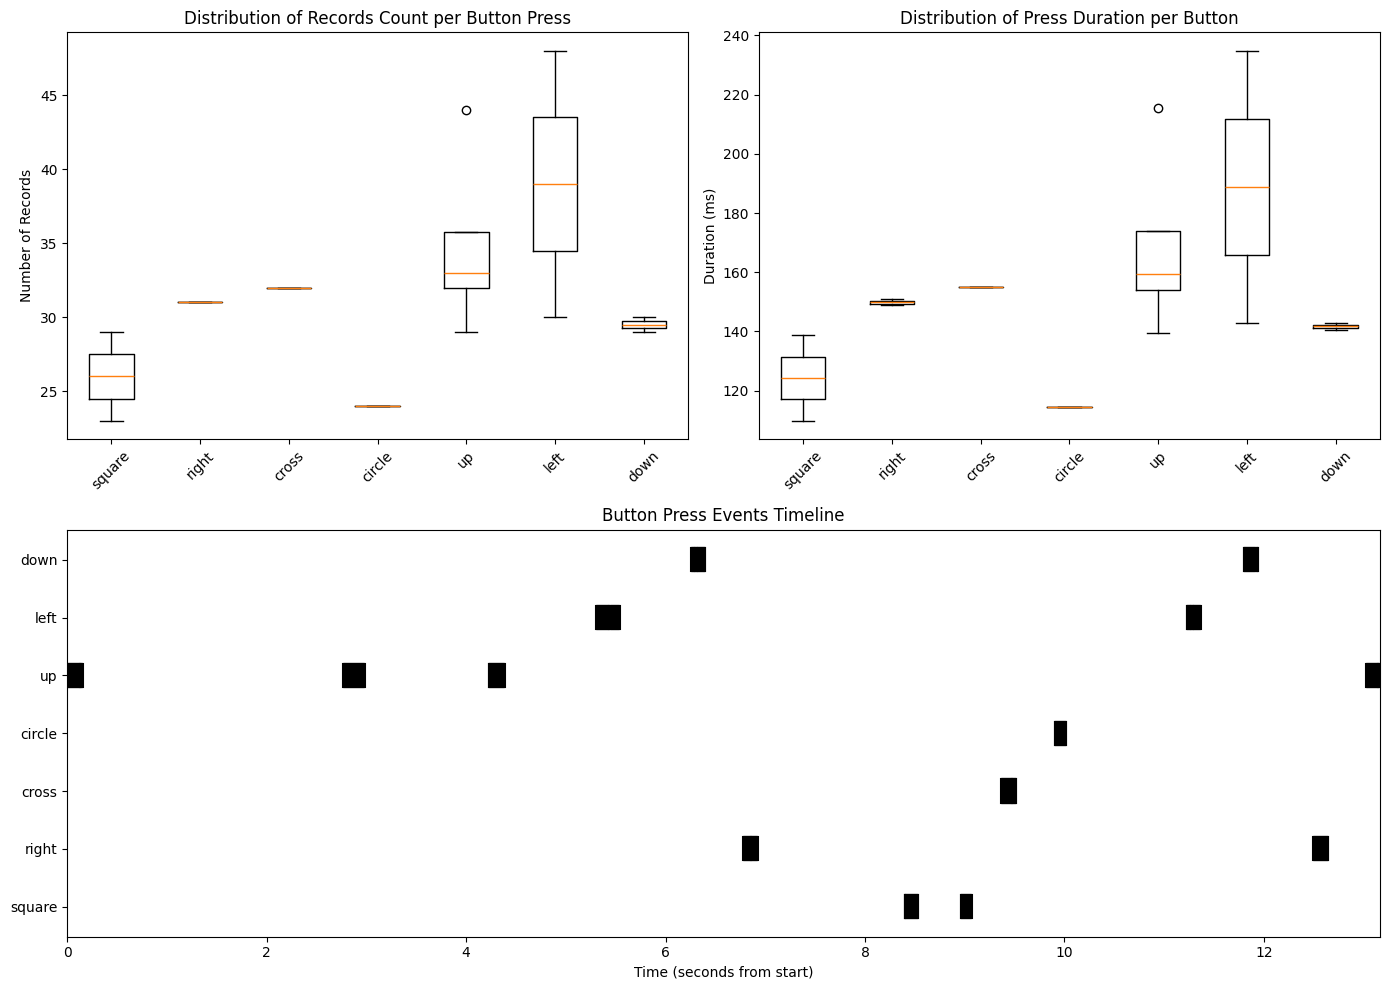

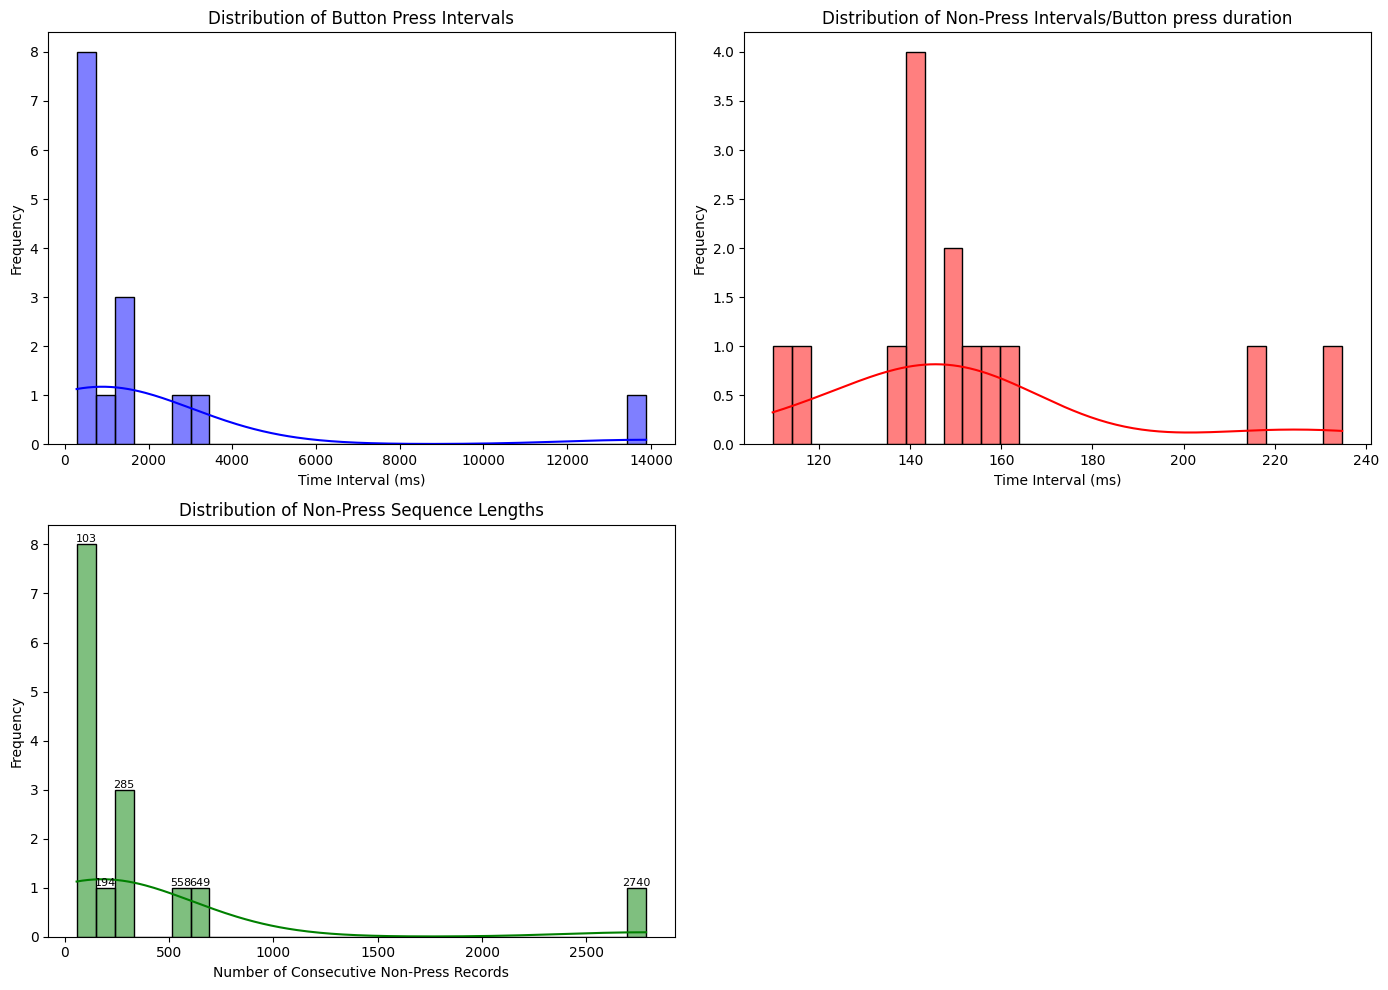


Press Intervals: Mean = 1858.36 ms, Std = 3432.21 ms
Non-Press Intervals: Mean = 153.75 ms, Std = 33.71 ms
No button sequences detected in the data.

Most pressed button: up (4 times)
Button with longest average press: cross (155.04 ms)


In [28]:
analyze_button_presses_with_intervals(df=df)

The interval between the button press and non-press will define the prepare data length

### 1.2 Extract method 

- 100 records: 50 before press, 50 after press
- reog to new dataframe

In [32]:
def extract_press_events(csv_file, output_file):
    """
    Extract button press events from a CSV file and save them as a new dataset.
    Each event contains 100 records: 50 before the first button press and 50 after.
    Each event is assigned a group_index to identify which segment it belongs to.
    
    Parameters:
    csv_file (str): Path to the input CSV file.
    output_file (str): Path to save the output CSV file.
    """
    # Load data
    df = pd.read_csv(csv_file)
    
    # Ensure timestamp is datetime if present
    if 'timestamp' in df.columns and df['timestamp'].dtype == 'object':
        df['timestamp'] = pd.to_datetime(df['timestamp'])
    
    # Identify indices where button press starts (first occurrence of a non-'none' value after 'none')
    press_indices = df.index[df['button_press'].shift(1, fill_value='none') == 'none']
    press_indices = press_indices[df.loc[press_indices, 'button_press'] != 'none']
    
    # Extract events (50 records before and 50 after each detected press) 100 is too long may acuse the overlap
    event_segments = []
    for group_idx, idx in enumerate(press_indices):
        start_idx = max(0, idx - 50)  # Ensure index does not go below 0
        end_idx = min(len(df), idx + 50)  # Ensure index does not exceed dataset length
        segment = df.iloc[start_idx:end_idx].copy()
        segment['group_index'] = group_idx  # Add group_index to identify the segment
        event_segments.append(segment)
    
    # Concatenate all event segments into a new DataFrame
    extracted_data = pd.concat(event_segments).reset_index(drop=True)
    
    # Save extracted data to a new CSV file
    extracted_data.to_csv(output_file, index=False)
    print(f"Extracted data saved to {output_file}")


# 100 + 100 is too long for the quick change of the button pressing, cause the overlap in the data 

In [33]:
# Rename the output as xxx.csv to xxx_pro.csv
# 
import os 

file_name = os.path.basename(file_path)
file_base, file_ext = os.path.splitext(file_name)
file_out = os.path.join(os.path.dirname(file_path), f"{file_base}_pro{file_ext}")

extract_press_events(file_path,file_out)

Extracted data saved to ../data\controller_data_user1_20250307_112616_pro.csv


Processed data shape: (1400, 9)

First few rows of processed data:


,timestamp,button_press,gyro_pitch,gyro_yaw,gyro_roll,acc_x,acc_y,acc_z,user_id
0,2025-03-07 11:26:30.229072,none,-1033,7907,-2113,36,-15,19,user1
1,2025-03-07 11:26:30.234104,none,-1055,7870,-2135,34,-15,22,user1
2,2025-03-07 11:26:30.239138,none,-1068,7897,-2141,24,-13,24,user1
3,2025-03-07 11:26:30.244168,none,-1102,7854,-2144,17,-10,26,user1
4,2025-03-07 11:26:30.249582,none,-1032,7844,-2143,-4,-2,34,user1



Button press events in processed data:


button_press
up        139
left       78
right      62
down       59
square     52
cross      32
circle     24
Name: count, dtype: int64

Detected buttons: circle, cross, down, left, right, square, up


,button,count,avg_sequence_length,avg_duration_ms,last_press
4,up,4,34.75,168.396,2025-03-07 11:26:43.644303
1,right,2,31.00,149.826,2025-03-07 11:26:43.127398
0,square,2,26.00,124.262,2025-03-07 11:26:39.552093
6,down,2,29.50,141.712,2025-03-07 11:26:42.421261
5,left,2,39.00,188.871,2025-03-07 11:26:41.847694
2,cross,1,32.00,155.041,2025-03-07 11:26:39.999734
3,circle,1,24.00,114.504,2025-03-07 11:26:40.497528


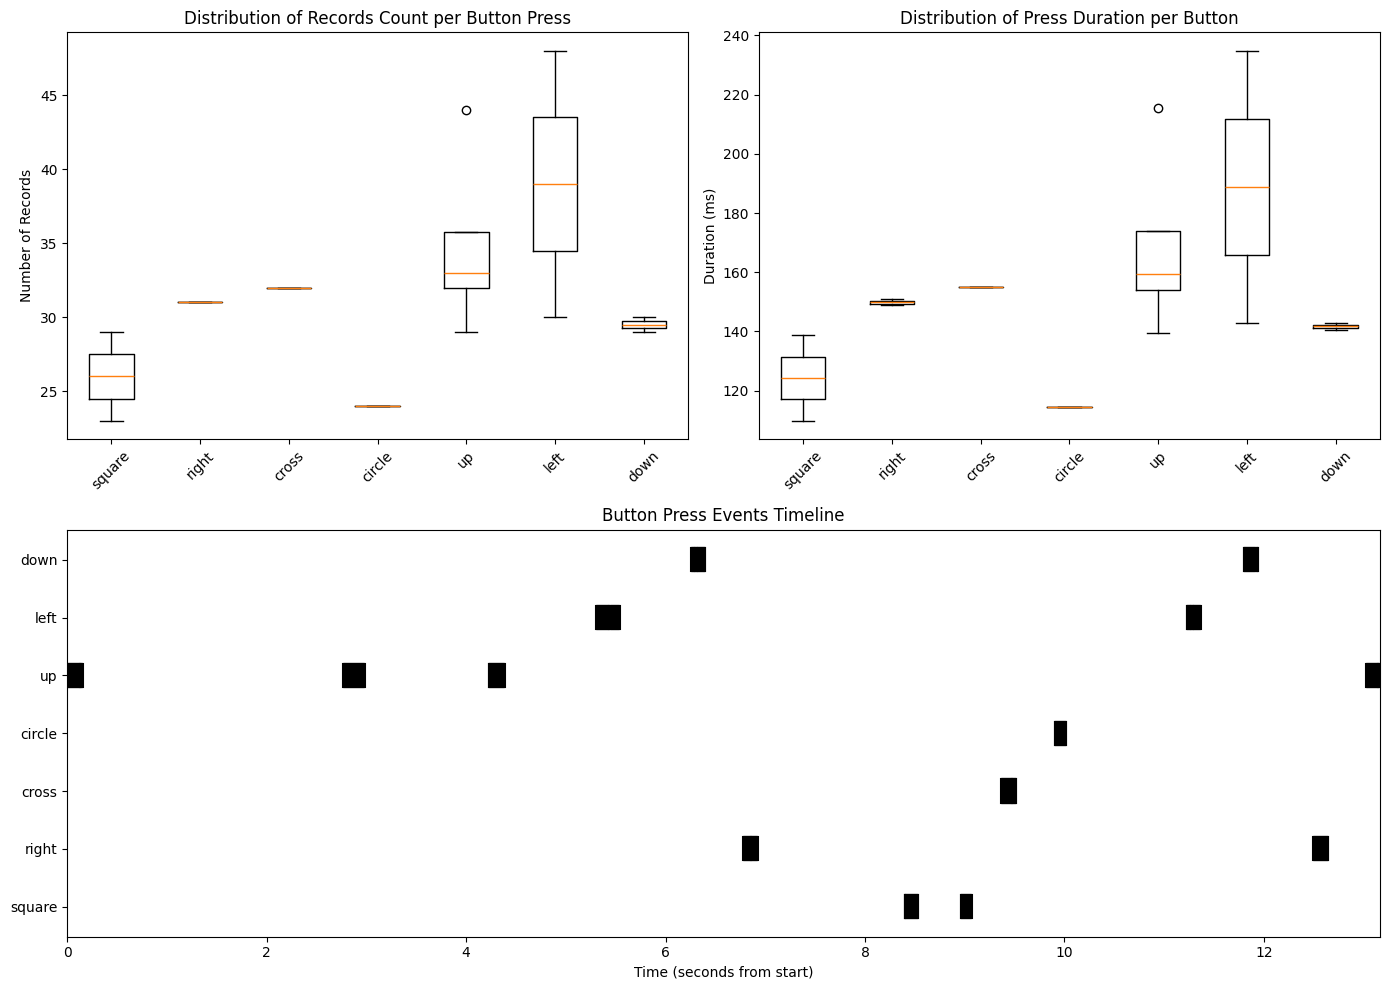

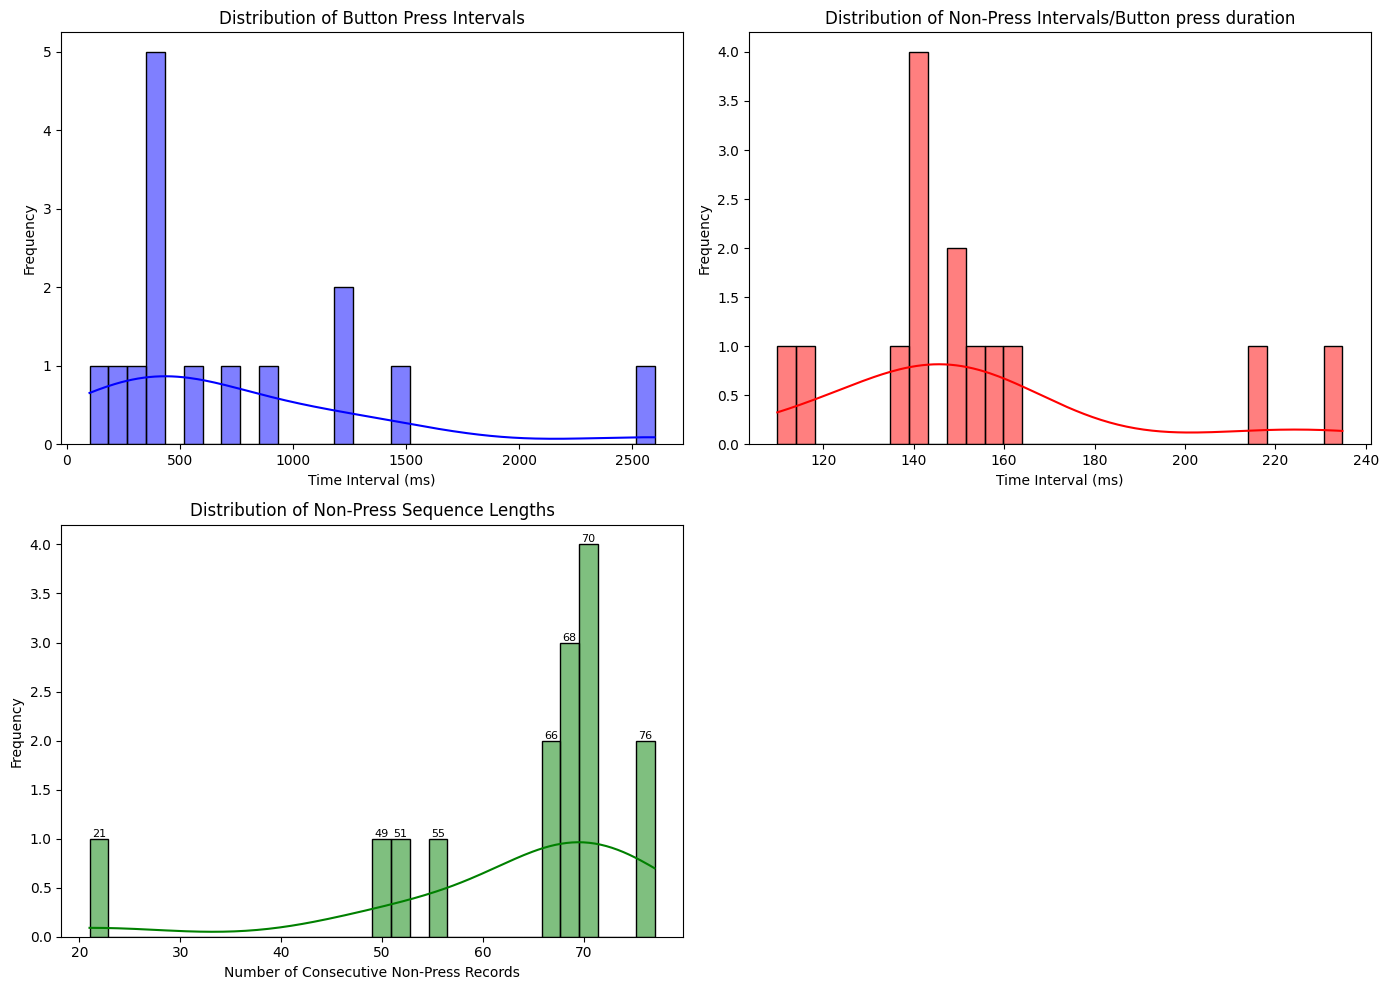


Press Intervals: Mean = 748.45 ms, Std = 653.06 ms
Non-Press Intervals: Mean = 153.75 ms, Std = 33.71 ms
No button sequences detected in the data.

Most pressed button: up (4 times)
Button with longest average press: cross (155.04 ms)


In [31]:
# compare the extra or post-extra

# read the file_out into the df_post
df_post = pd.read_csv(file_out)

# Display basic information about the processed data
print(f"Processed data shape: {df_post.shape}")
print("\nFirst few rows of processed data:")
display(df_post.head())

# Count button press events by type
button_counts = df_post[df_post['button_press'] != 'none']['button_press'].value_counts()
print("\nButton press events in processed data:")
display(button_counts)


analyze_button_presses_with_intervals(df=df_post)


### 1.3 Visualize data

In [44]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def plot_event_durations(csv_file):
    """
    Plot two visualizations:
    1. Sequence of events (none/press/none) in each group showing time relation
    2. Time span (duration) of each group broken down by event types (none/press/none)
    
    Parameters:
    csv_file (str): Path to the extracted CSV file.
    """
    # Load the extracted dataset
    df = pd.read_csv(csv_file)
    
    # Ensure timestamp is datetime if present
    if 'timestamp' in df.columns and df['timestamp'].dtype == 'object':
        df['timestamp'] = pd.to_datetime(df['timestamp'])
    
    # Group by group_index and calculate counts and durations
    group_data = []
    time_span_data = []
    
    for group_idx, group_df in df.groupby('group_index'):
        # Calculate time span of the group
        if 'timestamp' in group_df.columns:
            time_span = (group_df['timestamp'].max() - group_df['timestamp'].min()).total_seconds() * 1000  # in milliseconds
        else:
            time_span = len(group_df)  # If no timestamp, use record count
        
        # Analyze the sequence pattern (none-press-none)
        events = group_df['button_press'].tolist()
        
        # Find the first non-none event index
        first_press_idx = next((i for i, e in enumerate(events) if e != 'none'), None)
        
        # Find the last non-none event index
        last_press_idx = next((len(events) - 1 - i for i, e in enumerate(reversed(events)) if e != 'none'), None)
        
        # Calculate the counts for each segment
        pre_none_count = first_press_idx if first_press_idx is not None else 0
        press_count = group_df[group_df['button_press'] != 'none'].shape[0]
        post_none_count = len(events) - last_press_idx - 1 if last_press_idx is not None else 0
        
        group_data.append({
            'group_index': group_idx, 
            'pre_none_count': pre_none_count,
            'press_count': press_count, 
            'post_none_count': post_none_count,
            'total_count': len(events)
        })
        
        # Calculate time spans for each segment
        if 'timestamp' in group_df.columns:
            sorted_group = group_df.sort_values('timestamp')
            timestamps = sorted_group['timestamp'].tolist()
            
            # Calculate time spans in milliseconds
            pre_none_time = 0
            press_time = 0
            post_none_time = 0
            
            if first_press_idx is not None and first_press_idx > 0:
                pre_none_time = (timestamps[first_press_idx] - timestamps[0]).total_seconds() * 1000
            
            if first_press_idx is not None and last_press_idx is not None:
                press_time = (timestamps[last_press_idx] - timestamps[first_press_idx]).total_seconds() * 1000
            
            if last_press_idx is not None and last_press_idx < len(timestamps) - 1:
                post_none_time = (timestamps[-1] - timestamps[last_press_idx]).total_seconds() * 1000
            
            time_span_data.append({
                'group_index': group_idx,
                'pre_none_time': pre_none_time,
                'press_time': press_time,
                'post_none_time': post_none_time,
                'total_time': time_span
            })
        else:
            # If no timestamp, use record counts as proxy for time
            time_span_data.append({
                'group_index': group_idx,
                'pre_none_time': pre_none_count,
                'press_time': press_count,
                'post_none_time': post_none_count,
                'total_time': len(events)
            })
    
    # Convert to DataFrames
    group_df = pd.DataFrame(group_data)
    time_span_df = pd.DataFrame(time_span_data)
    
    # Create a figure with two subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
    
    # Plot 1: Stacked bar chart showing the time relation (none-press-none) per group
    group_df.plot(
        x='group_index', 
        y=['pre_none_count', 'press_count', 'post_none_count'],
        kind='bar',
        stacked=True,
        ax=ax1,
        color=['#1f77b4', '#ff7f0e', '#2ca02c'],
        legend=True
    )
    ax1.set_xlabel("Group Index")
    ax1.set_ylabel("Count")
    ax1.set_title("Event Sequence Pattern per Group")
    ax1.legend(["Pre-Press (none)", "Press Events", "Post-Press (none)"])
    ax1.tick_params(axis='x', rotation=45)
    ax1.grid(True, linestyle="--", alpha=0.5)
    
    # Plot 2: Stacked bar chart showing time spans broken down by event types
    time_span_df.plot(
        x='group_index', 
        y=['pre_none_time', 'press_time', 'post_none_time'],
        kind='bar',
        stacked=True,
        ax=ax2,
        color=['#1f77b4', '#ff7f0e', '#2ca02c'],
        legend=True
    )
    ax2.set_xlabel("Group Index")
    ax2.set_ylabel("Time Span (milliseconds)")
    ax2.set_title("Time Span of Each Group by Event Type")
    ax2.legend(["Pre-Press (none)", "Press Events", "Post-Press (none)"])
    ax2.tick_params(axis='x', rotation=45)
    ax2.grid(True, linestyle="--", alpha=0.5)
    
    plt.tight_layout()
    plt.show()


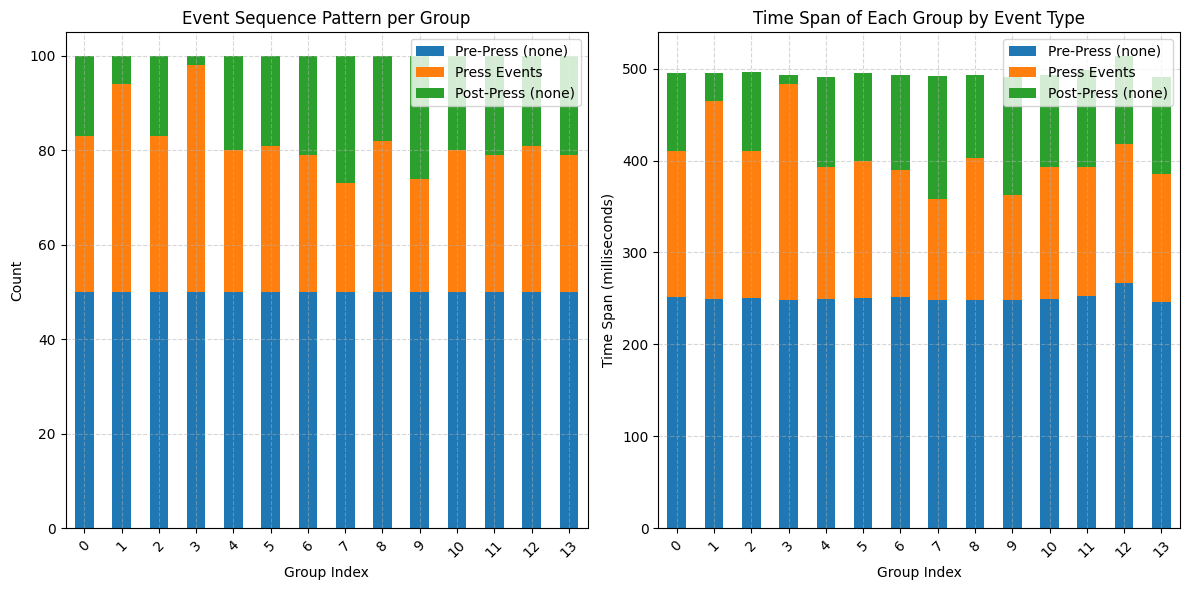

In [45]:
plot_event_durations(file_out)

In [48]:
# Function to plot the inertial sensor data over time
def plot_inertial_data(file_path):
    """
    Plot the gyroscope and accelerometer data over time to visualize motion patterns.
    
    Args:
        file_path: Path to the CSV file containing controller data with timestamp and sensor readings
    """
    # Load the data from CSV file
    df = pd.read_csv(file_path)
    
    # Create a figure with two rows of subplots
    fig, axes = plt.subplots(2, 1, figsize=(14, 10), sharex=True)
    
    # Convert timestamp to datetime if it's not already
    if not pd.api.types.is_datetime64_any_dtype(df['timestamp']):
        df['timestamp'] = pd.to_datetime(df['timestamp'])
    
    # Plot gyroscope data (top subplot)
    axes[0].plot(df['timestamp'], df['gyro_pitch'], label='Pitch', color='#1f77b4')
    axes[0].plot(df['timestamp'], df['gyro_yaw'], label='Yaw', color='#ff7f0e')
    axes[0].plot(df['timestamp'], df['gyro_roll'], label='Roll', color='#2ca02c')
    axes[0].set_ylabel('Gyroscope Reading')
    axes[0].set_title('Gyroscope Data Over Time')
    axes[0].legend()
    axes[0].grid(True, linestyle='--', alpha=0.7)
    
    # Plot accelerometer data (bottom subplot)
    axes[1].plot(df['timestamp'], df['acc_x'], label='X-axis', color='#d62728')
    axes[1].plot(df['timestamp'], df['acc_y'], label='Y-axis', color='#9467bd')
    axes[1].plot(df['timestamp'], df['acc_z'], label='Z-axis', color='#8c564b')
    axes[1].set_xlabel('Time')
    axes[1].set_ylabel('Accelerometer Reading')
    axes[1].set_title('Accelerometer Data Over Time')
    axes[1].legend()
    axes[1].grid(True, linestyle='--', alpha=0.7)
    
    # Highlight button press events if they exist
    if 'button_press' in df.columns:
        press_events = df[df['button_press'] != 'none']
        if not press_events.empty:
            for ax in axes:
                for idx, event in press_events.iterrows():
                    ax.axvline(x=event['timestamp'], color='red', alpha=0.3, linestyle=':')
    
    plt.tight_layout()
    plt.show()



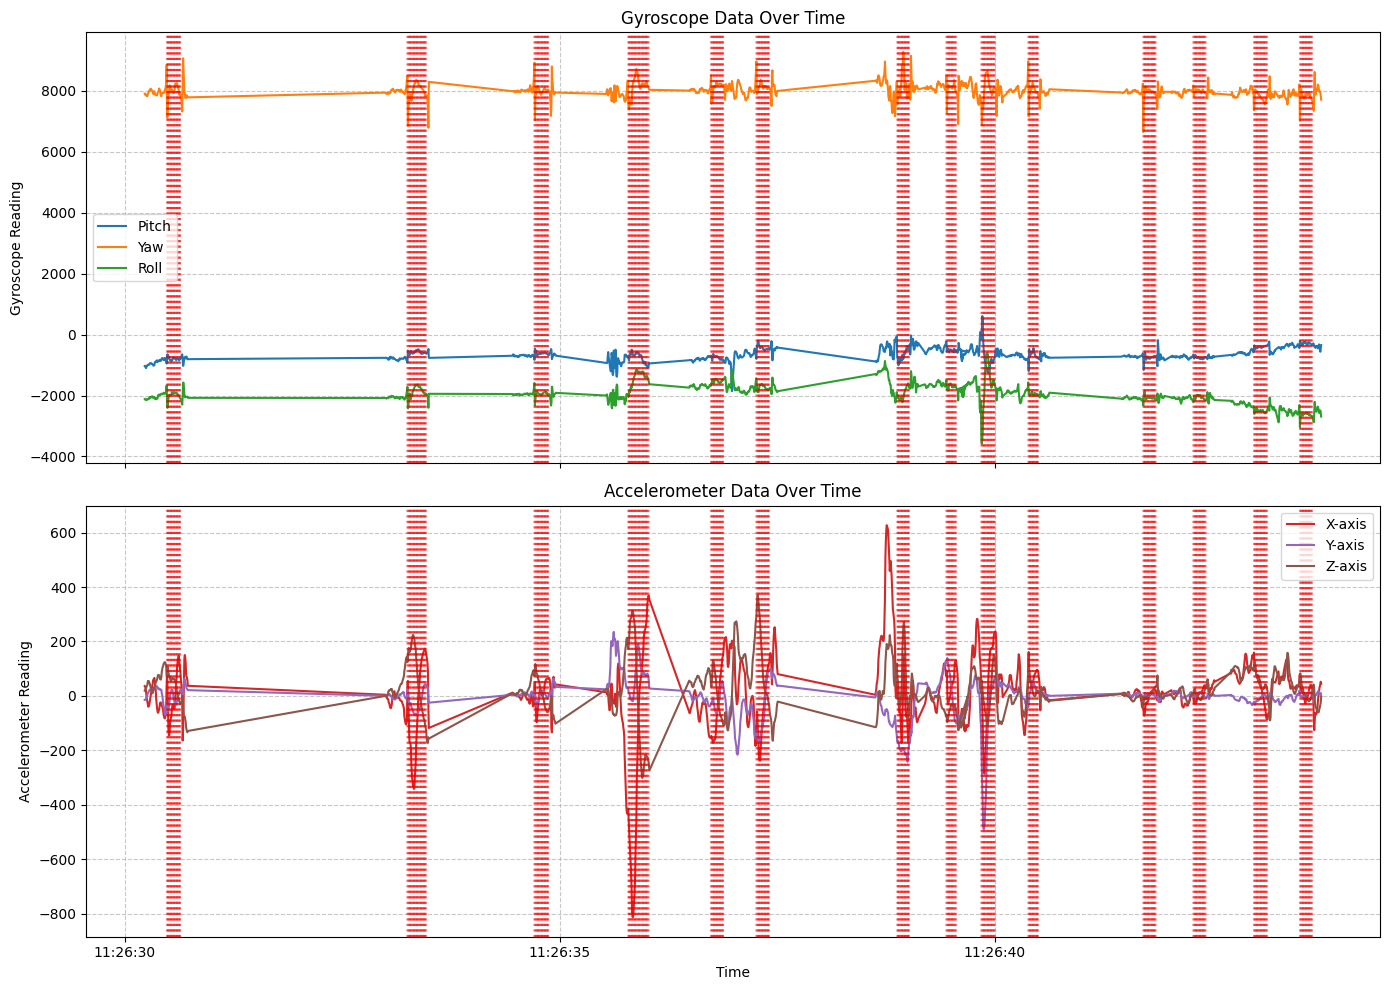

In [49]:
# Plot the inertial data from the loaded file
plot_inertial_data(file_out)

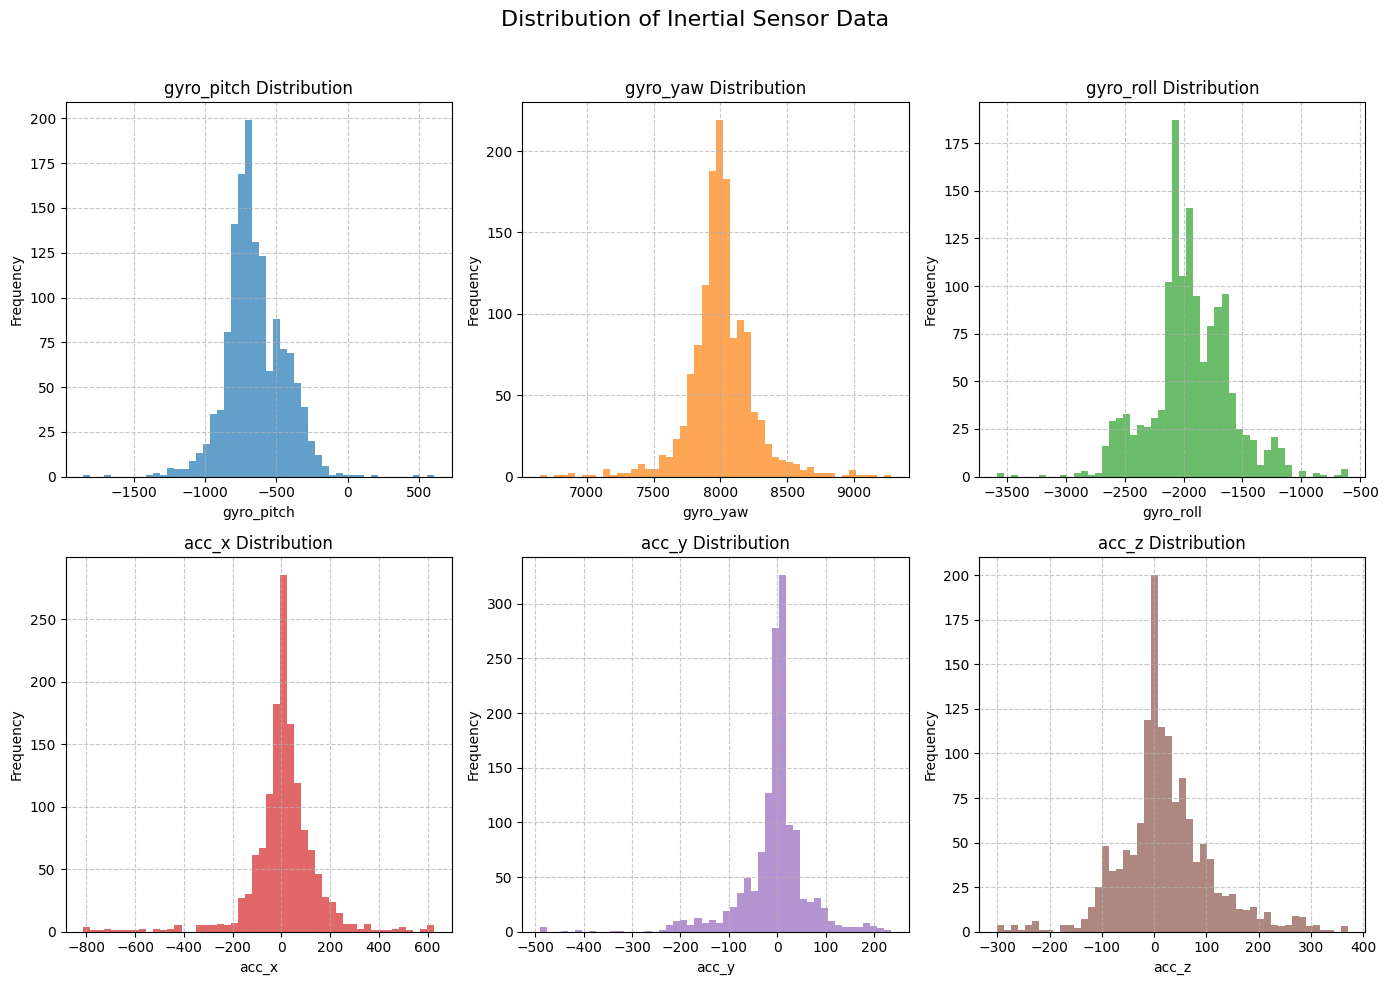

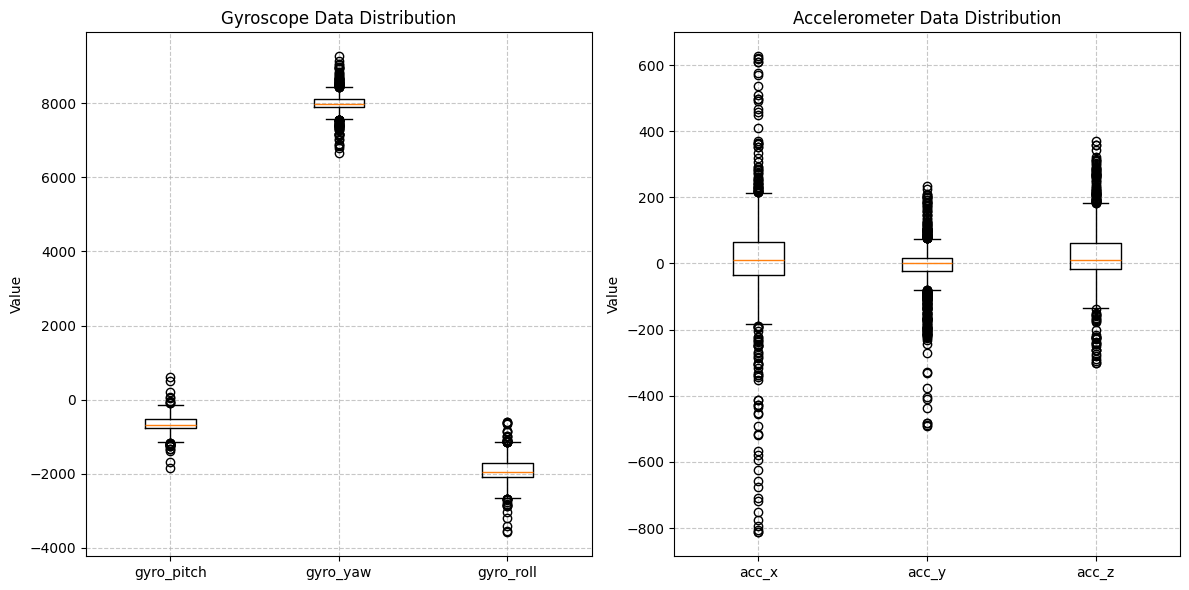

In [52]:
# distribution of inertial data 
def plot_inertial_distributions(df):
    """
    Plot distributions of inertial data (gyroscope and accelerometer) from a DataFrame.
    
    Parameters:
    -----------
    df : pandas.DataFrame
        DataFrame containing gyroscope and accelerometer data columns
    """
    # Check if the required columns exist
    required_cols = ['gyro_pitch', 'gyro_yaw', 'gyro_roll', 'acc_x', 'acc_y', 'acc_z']
    for col in required_cols:
        if col not in df.columns:
            print(f"Error: Column '{col}' not found in the DataFrame")
            return
    
    # Create a figure with 6 subplots for individual distributions
    fig, axes = plt.subplots(2, 3, figsize=(14, 10))
    fig.suptitle('Distribution of Inertial Sensor Data', fontsize=16)
    
    # Flatten the axes array for easier iteration
    axes = axes.flatten()
    
    # Plot histograms for each sensor attribute
    for i, col in enumerate(required_cols):
        axes[i].hist(df[col], bins=50, color=f'C{i}', alpha=0.7)
        axes[i].set_title(f'{col} Distribution')
        axes[i].set_xlabel(col)
        axes[i].set_ylabel('Frequency')
        axes[i].grid(True, linestyle='--', alpha=0.7)
    
    plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust layout to make room for the title
    plt.show()
    
    # Create a boxplot to show all distributions together
    plt.figure(figsize=(12, 6))
    
    # Create separate boxplots for gyroscope and accelerometer data due to different scales
    plt.subplot(1, 2, 1)
    gyro_data = df[['gyro_pitch', 'gyro_yaw', 'gyro_roll']]
    plt.boxplot(gyro_data.values, tick_labels=gyro_data.columns)
    plt.title('Gyroscope Data Distribution')
    plt.ylabel('Value')
    plt.grid(True, linestyle='--', alpha=0.7)
    
    plt.subplot(1, 2, 2)
    acc_data = df[['acc_x', 'acc_y', 'acc_z']]
    plt.boxplot(acc_data.values, tick_labels=acc_data.columns)
    plt.title('Accelerometer Data Distribution')
    plt.ylabel('Value')
    plt.grid(True, linestyle='--', alpha=0.7)
    
    plt.tight_layout()
    plt.show()

# Plot the distribution of inertial data from the loaded file
out_df=pd.read_csv(file_out)
plot_inertial_distributions(out_df)


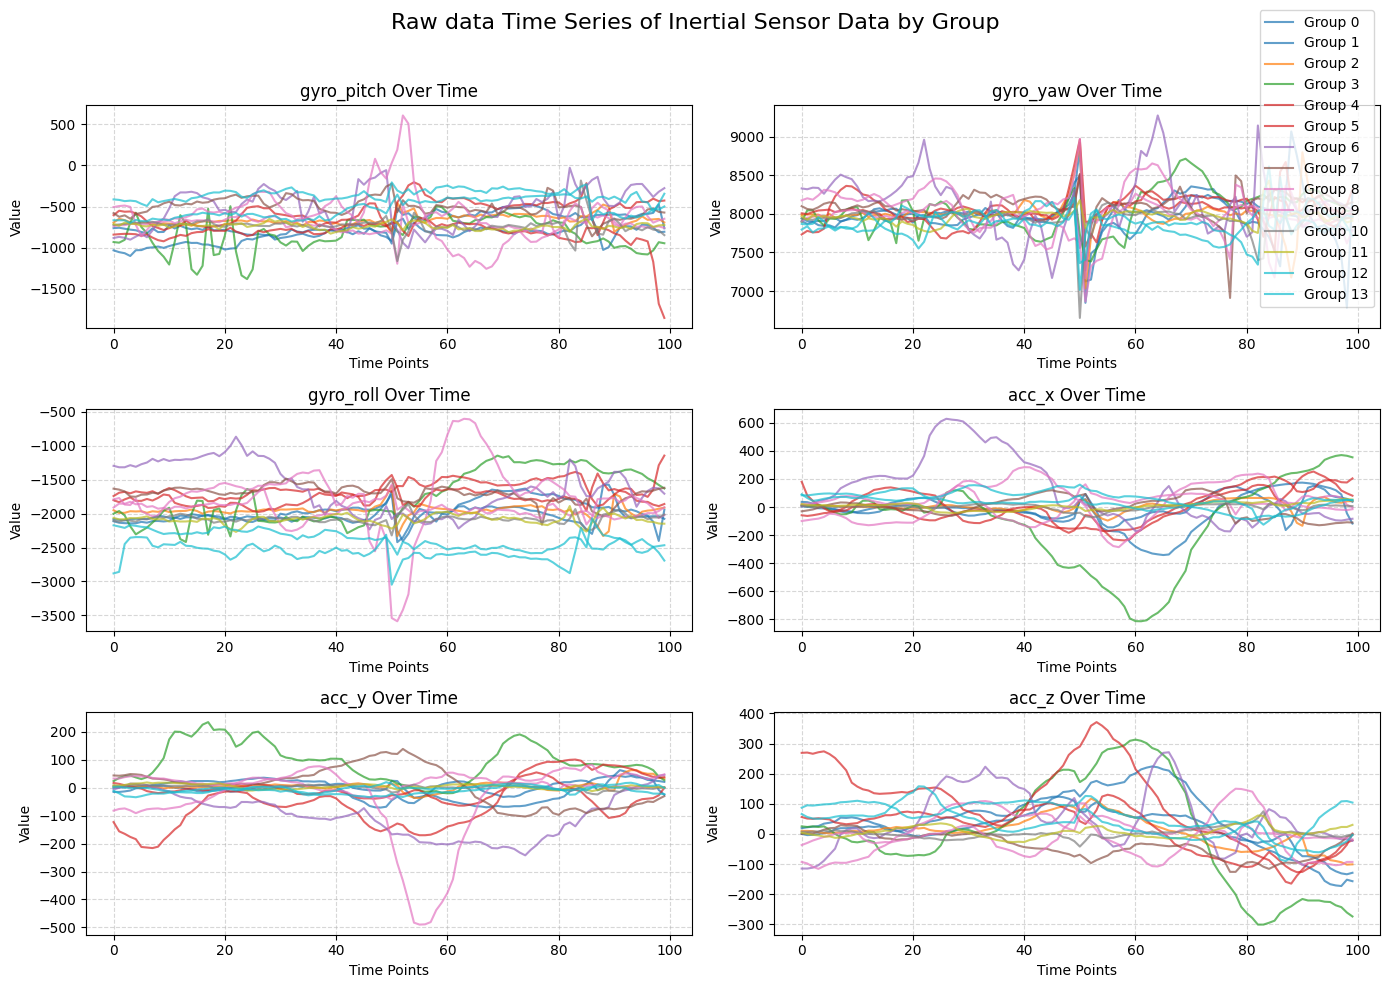

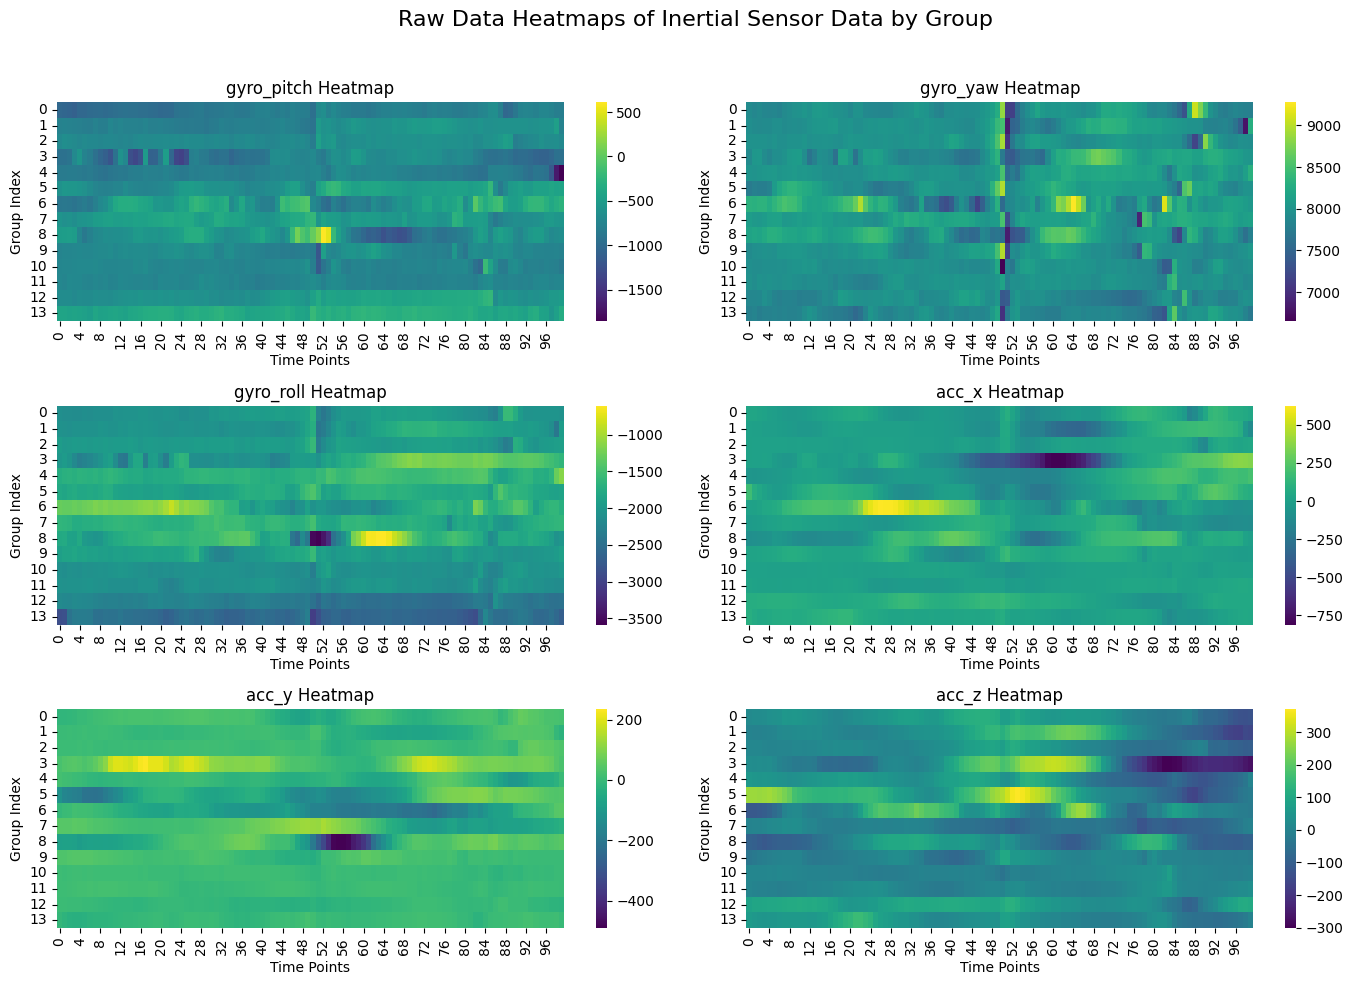

In [55]:
# plot all the group in one time-series 

def plot_groups_time_series(df,plotname=''):
    """
    Plot time-series data for all groups, with each group represented by a different color.
    Creates 6 subplots, one for each inertial attribute.
    """
    if 'group_index' not in df.columns:
        print("Error: 'group_index' column not found in DataFrame")
        return
    
    # Check for required columns
    required_cols = ['gyro_pitch', 'gyro_yaw', 'gyro_roll', 'acc_x', 'acc_y', 'acc_z']
    for col in required_cols:
        if col not in df.columns:
            print(f"Error: Column '{col}' not found in the DataFrame")
            return
    
    # Create a figure with 6 subplots for each attribute
    fig, axes = plt.subplots(3, 2, figsize=(14, 10))
    fig.suptitle(f'{plotname} Time Series of Inertial Sensor Data by Group', fontsize=16)
    
    # Flatten the axes array for easier iteration
    axes = axes.flatten()
    
    # Get unique groups
    groups = df['group_index'].unique()
    
    # Create a color map for different groups
    colors = plt.cm.tab10(np.linspace(0, 1, len(groups)))
    
    # Plot each attribute
    for i, col in enumerate(required_cols):
        for j, group in enumerate(groups):
            group_data = df[df['group_index'] == group]
            axes[i].plot(range(len(group_data)), group_data[col], 
                         color=colors[j], label=f'Group {group}', alpha=0.7)
        
        axes[i].set_title(f'{col} Over Time')
        axes[i].set_xlabel('Time Points')
        axes[i].set_ylabel('Value')
        axes[i].grid(True, linestyle='--', alpha=0.5)
    
    # Add a single legend for the entire figure
    handles, labels = axes[0].get_legend_handles_labels()
    fig.legend(handles, labels, loc='upper right', bbox_to_anchor=(0.99, 0.99))
    
    plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust layout to make room for the title
    plt.show()


def plot_groups_heatmaps(df, plotname=''):
    """
    Plot heatmaps for each inertial attribute across all groups.
    Each heatmap shows the time-series data where rows represent different groups (actions)
    and columns represent time points.
    """
    if 'group_index' not in df.columns:
        print("Error: 'group_index' column not found in DataFrame")
        return

    # Check for required columns
    required_cols = ['gyro_pitch', 'gyro_yaw', 'gyro_roll', 'acc_x', 'acc_y', 'acc_z']
    for col in required_cols:
        if col not in df.columns:
            print(f"Error: Column '{col}' not found in the DataFrame")
            return

    # Create a figure with 6 subplots for each attribute
    fig, axes = plt.subplots(3, 2, figsize=(14, 10))
    fig.suptitle(f'{plotname} Heatmaps of Inertial Sensor Data by Group', fontsize=16)

    # Flatten axes array for easier iteration
    axes = axes.flatten()

    # Get unique groups sorted for consistent ordering
    groups = sorted(df['group_index'].unique())

    # Loop over each attribute to create its heatmap
    for i, col in enumerate(required_cols):
        # Build a 2D matrix where each row is the time-series for one group
        data_matrix = []
        for group in groups:
            group_data = df[df['group_index'] == group][col].values
            data_matrix.append(group_data)
        data_matrix = np.array(data_matrix)

        # Plot the heatmap for this attribute
        sns.heatmap(data_matrix, ax=axes[i], cmap='viridis', cbar=True)
        axes[i].set_title(f'{col} Heatmap')
        axes[i].set_xlabel('Time Points')
        axes[i].set_ylabel('Group Index')
        # Adjust y-axis ticks to be centered on each heatmap row
        axes[i].set_yticks(np.arange(len(groups)) + 0.5)
        axes[i].set_yticklabels(groups)

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()


# Plot time-series data for all groups
plot_groups_time_series(out_df,plotname='Raw data')
plot_groups_heatmaps(out_df,'Raw Data')

#### 1.3.1 Visual for one btn

In [56]:
cross_btn_csv="controller_data_user1_20250309_202625_cr_btn.csv"
csv_folder='../data/'

In [57]:

extract_press_events(csv_folder+cross_btn_csv,csv_folder+'cross_btn_press_events.csv')


Extracted data saved to ../data/cross_btn_press_events.csv


In [58]:
crs_btn_csv_ext='../data/controller_data_user1_20250309_202625_cr_btn_pro.csv'



In [62]:
import numpy as np
import matplotlib.pyplot as plt

def plot_groups_time_series_same_btn(df, plotname=''):
    """
    Plot time-series data for all groups, using the same color for all lines.
    Adds transparency to show the density of overlapping curves and plots the mean with standard deviation.
    Creates 6 subplots, one for each inertial attribute.
    """
    if 'group_index' not in df.columns:
        print("Error: 'group_index' column not found in DataFrame")
        return
    
    # Check for required columns
    required_cols = ['gyro_pitch', 'gyro_yaw', 'gyro_roll', 'acc_x', 'acc_y', 'acc_z']
    for col in required_cols:
        if col not in df.columns:
            print(f"Error: Column '{col}' not found in the DataFrame")
            return
    
    # Create a figure with 6 subplots for each attribute
    fig, axes = plt.subplots(3, 2, figsize=(14, 10))
    fig.suptitle(f'{plotname} Time Series of Inertial Sensor Data', fontsize=16)
    
    # Flatten the axes array for easier iteration
    axes = axes.flatten()
    
    # Get unique groups
    groups = df['group_index'].unique()
    
    # Define a single color for all groups
    line_color = 'blue'  # Change this to any preferred color
    
    # Plot each attribute
    for i, col in enumerate(required_cols):
        all_group_data = []
        
        for group in groups:
            group_data = df[df['group_index'] == group][col].values
            all_group_data.append(group_data)
            axes[i].plot(range(len(group_data)), group_data, 
                         color=line_color, alpha=0.2)  # Use transparency
        
        # Compute mean and standard deviation
        all_group_data = np.array(all_group_data)
        mean_values = np.mean(all_group_data, axis=0)
        std_values = np.std(all_group_data, axis=0)
        
        # Plot mean with standard deviation as a shaded region
        axes[i].plot(range(len(mean_values)), mean_values, color='red', label='Mean')
        axes[i].fill_between(range(len(mean_values)), mean_values - std_values, mean_values + std_values,
                             color='red', alpha=0.3, label='Std Dev')
        
        axes[i].set_title(f'{col} Over Time')
        axes[i].set_xlabel('Time Points')
        axes[i].set_ylabel('Value')
        axes[i].grid(True, linestyle='--', alpha=0.5)
    
    plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust layout to make room for the title
    plt.show()

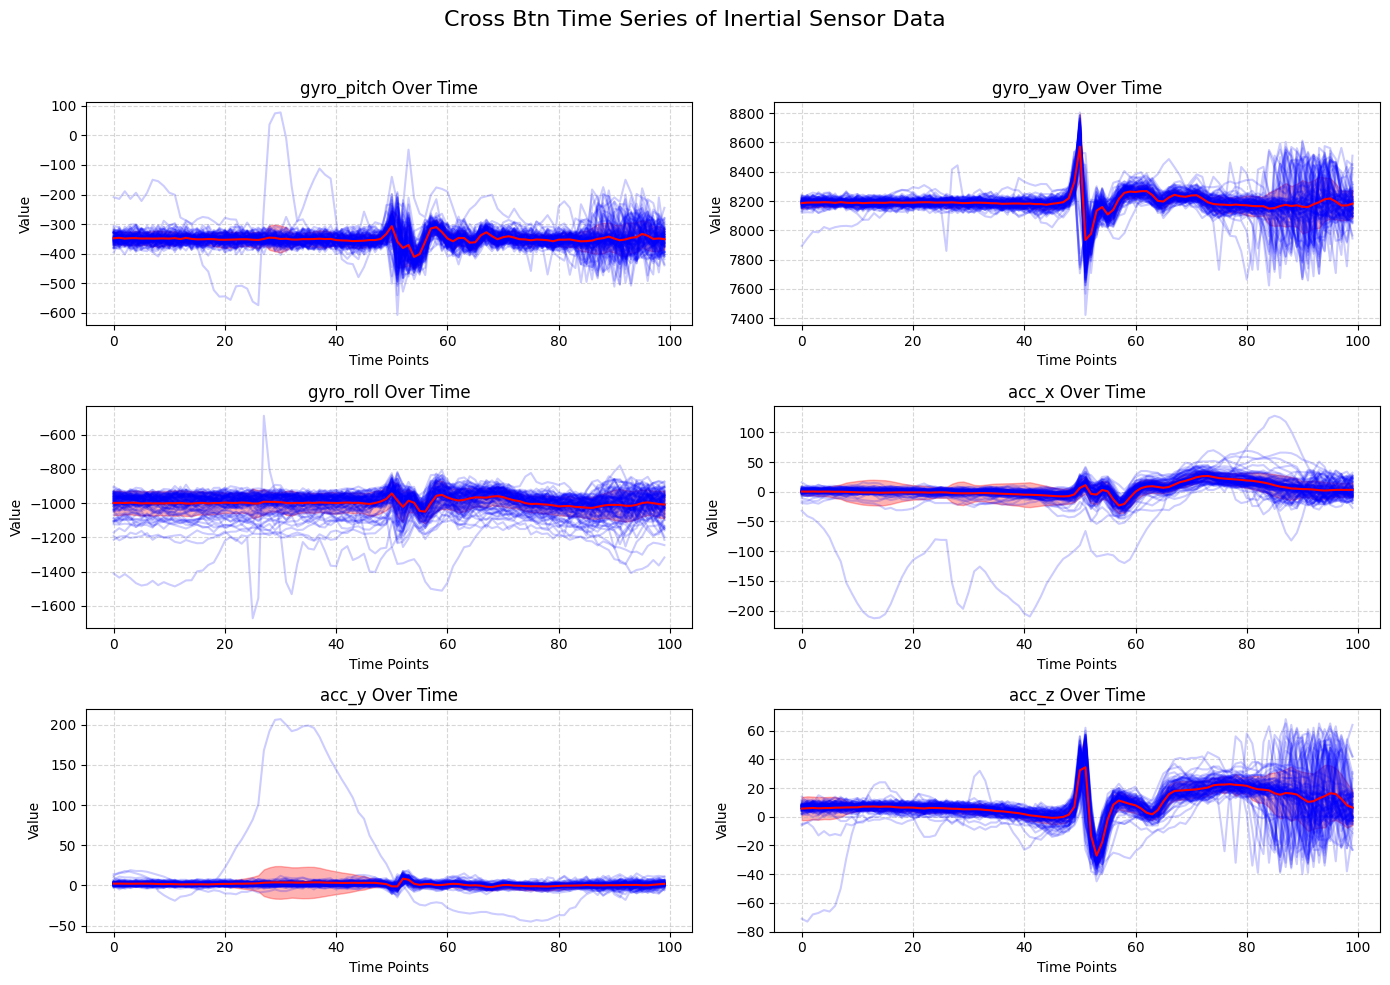

In [63]:
crs_df=pd.read_csv(crs_btn_csv_ext)
plot_groups_time_series_same_btn(crs_df,'Cross Btn')

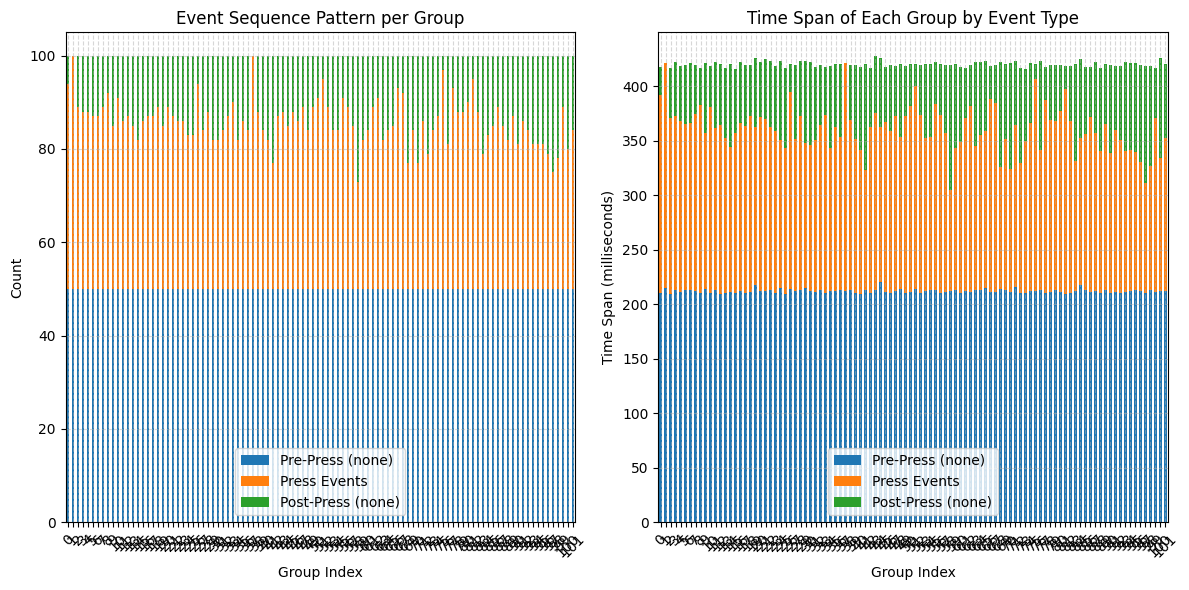

In [61]:
plot_event_durations(crs_btn_csv_ext)

In [67]:
# PCA
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

def apply_pca_and_plot(df, n_components=3):
    """
    Applies PCA on the inertial sensor data and plots the transformed components.
    
    Parameters:
    - df: DataFrame containing inertial sensor data with 'group_index'
    - n_components: Number of principal components to retain (default: 2)
    
    Returns:
    - Transformed PCA DataFrame
    """
    
    # Check if 'group_index' column exists
    if 'group_index' not in df.columns:
        print("Error: 'group_index' column not found in DataFrame")
        return
    
    # Define relevant features for PCA
    features = ['gyro_pitch', 'gyro_yaw', 'gyro_roll', 'acc_x', 'acc_y', 'acc_z']
    
    # Check if all features exist
    for col in features:
        if col not in df.columns:
            print(f"Error: Column '{col}' not found in the DataFrame")
            return
    
    # Extract features and standardize the data
    X = df[features].values
    X_scaled = StandardScaler().fit_transform(X)  # Mean=0, Variance=1
    
    # Apply PCA
    pca = PCA(n_components=n_components)
    X_pca = pca.fit_transform(X_scaled)
    
    # Create a new DataFrame with PCA results
    pca_df = pd.DataFrame(X_pca, columns=[f'PC{i+1}' for i in range(n_components)])
    pca_df['group_index'] = df['group_index'].values  # Keep group labels
    
    # Plot the PCA results
    plt.figure(figsize=(10, 6))
    
    if n_components == 2:
        # Scatter plot for 2D PCA
        scatter = plt.scatter(pca_df['PC1'], pca_df['PC2'], c=df['group_index'], cmap='viridis', alpha=0.7)
        plt.xlabel('Principal Component 1')
        plt.ylabel('Principal Component 2')
        plt.colorbar(scatter, label='Group Index')
    
    elif n_components == 3:
        # 3D scatter plot for 3D PCA
        from mpl_toolkits.mplot3d import Axes3D
        fig = plt.figure(figsize=(10, 7))
        ax = fig.add_subplot(111, projection='3d')
        scatter = ax.scatter(pca_df['PC1'], pca_df['PC2'], pca_df['PC3'], c=df['group_index'], cmap='viridis', alpha=0.7)
        ax.set_xlabel('Principal Component 1')
        ax.set_ylabel('Principal Component 2')
        ax.set_zlabel('Principal Component 3')
        fig.colorbar(scatter, label='Group Index')
    
    plt.title(f'PCA Visualization ({n_components} Components)')
    plt.show()
    
    return pca_df

<Figure size 1000x600 with 0 Axes>

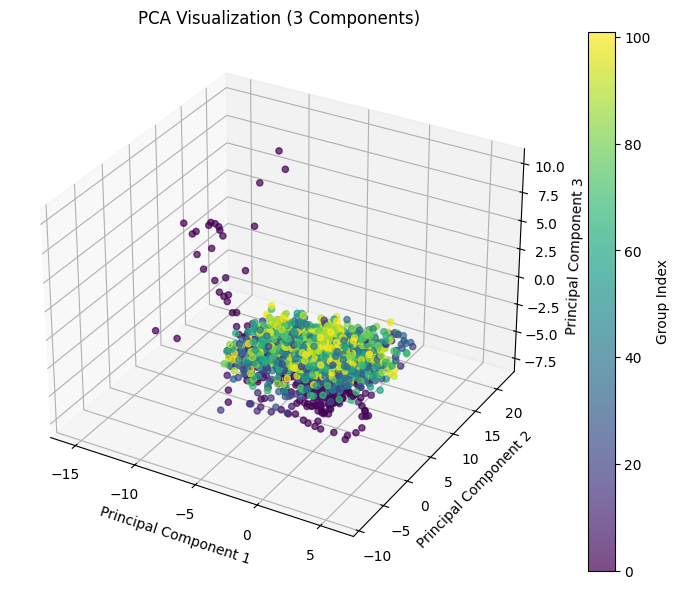

,PC1,PC2,PC3,group_index
0,-7.471891,1.885349,-3.721804,0
1,-7.822121,2.310619,-3.614522,0
2,-7.424235,3.300503,-3.515685,0
3,-7.854511,2.992566,-3.563631,0
4,-7.836062,3.773017,-3.960965,0
...,...,...,...,...
10195,-1.339717,-1.841388,-1.293083,101
10196,-0.587417,-0.595853,-0.331024,101
10197,-0.357279,-0.322830,0.666872,101
10198,-0.255398,-0.464220,-0.470280,101


In [68]:
apply_pca_and_plot(crs_df)

In [116]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

def reconstruct_and_plot_acc_relationships(df):
    """
    Reconstructs a 2D trajectory (displacement in X and Y) from accelerometer data 
    by double-integrating acceleration using timestamp differences for dt, and
    also creates two additional plots showing:
      - acc_x vs. acc_z
      - acc_y vs. acc_z
      
    Assumes the DataFrame has the following columns:
      - 'group_index'
      - 'timestamp' (in a format parseable by pd.to_datetime)
      - 'acc_x'
      - 'acc_y'
      - 'acc_z'
    
    All plots are rendered in blue with alpha=0.5 and without group labels.
    """
    
    # Check for required columns
    required_cols = ['group_index', 'timestamp', 'acc_x', 'acc_y', 'acc_z']
    for col in required_cols:
        if col not in df.columns:
            print(f"Error: Column '{col}' not found in the DataFrame")
            return
    
    groups = sorted(df['group_index'].unique())
    
    # Create a figure with 3 subplots (vertical layout)
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 15))
    
    for group in groups:
        # Filter and sort data by timestamp for each group
        group_data = df[df['group_index'] == group].sort_values(by='timestamp')
        
        # Convert timestamps to datetime objects and then to seconds since epoch
        timestamps = pd.to_datetime(group_data['timestamp']).values
        timestamps_seconds = np.array([ts.astype('float64') / 1e9 for ts in timestamps])
        
        # Extract accelerometer data
        acc_x = group_data['acc_x'].values
        acc_y = group_data['acc_y'].values
        acc_z = group_data['acc_z'].values
        
        n = len(timestamps_seconds)
        if n < 2:
            continue  # Not enough data to integrate or plot
        
        # Reconstruct trajectory (double integration for acc_x and acc_y)
        vel_x = np.zeros(n)
        vel_y = np.zeros(n)
        disp_x = np.zeros(n)
        disp_y = np.zeros(n)
        
        for j in range(1, n):
            dt = timestamps_seconds[j] - timestamps_seconds[j-1]  # dt in seconds
            vel_x[j] = vel_x[j-1] + acc_x[j] * dt
            vel_y[j] = vel_y[j-1] + acc_y[j] * dt
            
            disp_x[j] = disp_x[j-1] + vel_x[j] * dt
            disp_y[j] = disp_y[j-1] + vel_y[j] * dt
        
        # Plot the reconstructed trajectory (displacement X vs. displacement Y)
        ax1.plot(disp_x, disp_y, color='blue', alpha=0.5)
        
        # Plot the relationship: acc_x vs. acc_z
        ax2.plot(acc_x, acc_z, color='blue', alpha=0.5)
        
        # Plot the relationship: acc_y vs. acc_z
        ax3.plot(acc_y, acc_z, color='blue', alpha=0.5)
    
    # Set labels and titles for the subplots
    ax1.set_xlabel('Displacement X')
    ax1.set_ylabel('Displacement Y')
    ax1.set_title('Reconstructed 2D Trajectories')
    ax1.grid(True, linestyle='--', alpha=0.6)
    ax1.set_xlim(-0.5, 0.5)
    ax1.set_ylim(-0.1, 0.3)

    
    ax2.set_xlabel('acc_x')
    ax2.set_ylabel('acc_z')
    ax2.set_title('Relationship: acc_x vs. acc_z')
    ax2.grid(True, linestyle='--', alpha=0.6)
    
    ax3.set_xlabel('acc_y')
    ax3.set_ylabel('acc_z')
    ax3.set_title('Relationship: acc_y vs. acc_z')
    ax3.grid(True, linestyle='--', alpha=0.6)
    
    plt.tight_layout()
    plt.show()




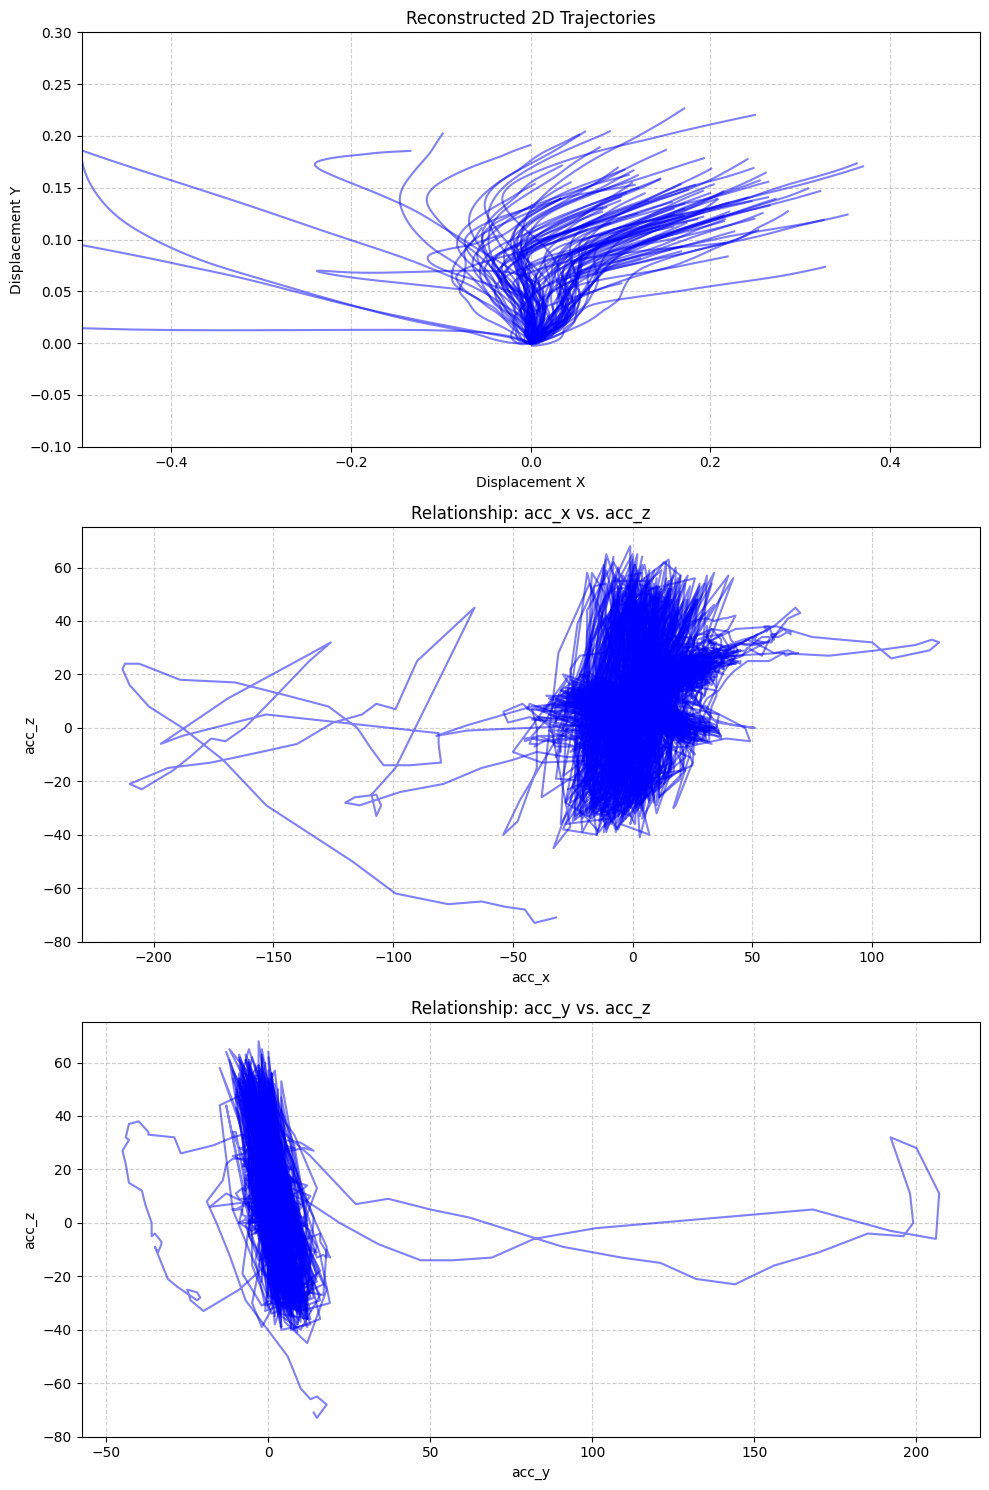

In [117]:
reconstruct_and_plot_acc_relationships(crs_df)

## 2.Baseline model 


### 2.1 SVM


In [120]:
import numpy as np
import pandas as pd
from sklearn.svm import OneClassSVM
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split  # Import the missing function


def extract_features_per_group(df, group_id):
    """Extracts features for a single group (one repetition of the action)."""
    group_data = df[df['group_index'] == group_id].sort_values(by='timestamp')
    timestamps = pd.to_datetime(group_data['timestamp']).values
    timestamps_seconds = np.array([ts.astype('float64') / 1e9 for ts in timestamps])
    acc_x = group_data['acc_x'].values
    acc_y = group_data['acc_y'].values
    acc_z = group_data['acc_z'].values
    gyro_pitch = group_data['gyro_pitch'].values
    gyro_yaw = group_data['gyro_yaw'].values
    gyro_roll = group_data['gyro_roll'].values

    n = len(timestamps_seconds)
    if n < 2:
        return None

    vel_x = np.zeros(n)
    vel_y = np.zeros(n)
    disp_x = np.zeros(n)
    disp_y = np.zeros(n)
    for j in range(1, n):
        dt = timestamps_seconds[j] - timestamps_seconds[j - 1]
        vel_x[j] = vel_x[j - 1] + acc_x[j] * dt
        vel_y[j] = vel_y[j - 1] + acc_y[j] * dt
        disp_x[j] = disp_x[j - 1] + vel_x[j] * dt
        disp_y[j] = disp_y[j - 1] + vel_y[j] * dt

    features = []
    for acc in [acc_x, acc_y, acc_z]:
        features.append(np.mean(acc))
        features.append(np.std(acc))
        features.append(np.sqrt(np.mean(acc**2)))
        features.append(np.percentile(acc, 75) - np.percentile(acc, 25))
    for gyro in [gyro_pitch, gyro_yaw, gyro_roll]:
        features.append(np.mean(gyro))
        features.append(np.std(gyro))
        features.append(np.sqrt(np.mean(gyro**2)))
        features.append(np.percentile(gyro, 75) - np.percentile(gyro, 25))

    total_distance = np.sum(np.sqrt(np.diff(disp_x)**2 + np.diff(disp_y)**2))
    bounding_box_area = (np.max(disp_x) - np.min(disp_x)) * (np.max(disp_y) - np.min(disp_y))
    if bounding_box_area ==0:
      trajectory_length_density = 0
    else:
      trajectory_length_density = total_distance / bounding_box_area
    centroid_x = np.mean(disp_x)
    centroid_y = np.mean(disp_y)
    features.extend([total_distance, bounding_box_area, centroid_x, centroid_y, trajectory_length_density])
    correlation = np.corrcoef(acc_x, acc_y)[0, 1]
    features.append(correlation)
    return np.array(features)

def train_and_evaluate_one_user(df):
    """Trains and evaluates the One-Class SVM on a single user's data."""

    # 0. Preprocessing: Handle Missing Values
    imputer = SimpleImputer(strategy='mean')
    df[['acc_x', 'acc_y', 'acc_z', 'gyro_pitch', 'gyro_yaw', 'gyro_roll']] = imputer.fit_transform(
        df[['acc_x', 'acc_y', 'acc_z', 'gyro_pitch', 'gyro_yaw', 'gyro_roll']])

    # 1. Feature Extraction (for ALL groups)
    all_features = []
    for group_id in df['group_index'].unique():
        features = extract_features_per_group(df, group_id)
        if features is not None:
            all_features.append(features)
    all_features = np.array(all_features)

    if len(all_features) == 0:
      print("no enough data")
      return
    # 2. Train/Test Split (split the *groups*, not the individual data points within a group)
    #    We'll use 80% for training and 20% for testing.
    if len(all_features) >= 2:
        train_features, test_features = train_test_split(all_features, test_size=0.2, random_state=42) # random_state for reproducibility
    else:
        print("Warning: Not enough groups to split into train and test. Need at least 2 groups.")
        return


    # 3. Data Scaling
    scaler = StandardScaler()
    train_features_scaled = scaler.fit_transform(train_features)
    test_features_scaled = scaler.transform(test_features)  # Use the same scaler

    # 4. Train One-Class SVM
    svm = OneClassSVM(kernel='rbf', nu=0.1, gamma='scale')  # Experiment with nu and gamma
    svm.fit(train_features_scaled)

    # 5. Evaluate (on both training and test sets)
    train_predictions = svm.predict(train_features_scaled)
    test_predictions = svm.predict(test_features_scaled)

    # Get decision function values (for thresholding and visualization)
    train_decision_values = svm.decision_function(train_features_scaled)
    test_decision_values = svm.decision_function(test_features_scaled)
    # Calculate outlier fractions
    train_outlier_fraction = (train_predictions == -1).sum() / len(train_predictions)
    test_outlier_fraction = (test_predictions == -1).sum() / len(test_predictions)

    print(f"Training outlier fraction: {train_outlier_fraction:.3f}")
    print(f"Test outlier fraction: {test_outlier_fraction:.3f}")
    # 6. Visualize Decision Function
    plt.figure(figsize=(12, 6))
    plt.hist(train_decision_values, bins=50, alpha=0.5, label='Train Decision Values')
    plt.hist(test_decision_values, bins=50, alpha=0.5, label='Test Decision Values')
    plt.xlabel("Decision Function Value")
    plt.ylabel("Frequency")
    plt.title("Distribution of Decision Function Values")
    plt.legend()
    plt.grid(True)
    plt.show()
    # 7. Set a Threshold (Example)
    threshold = -0.2  # Adjust this based on the histogram
    anomalous_train = train_decision_values < threshold
    anomalous_test = test_decision_values < threshold

    print(f"Number of anomalous groups (train): {anomalous_train.sum()} out of {len(train_features)}")
    print(f"Number of anomalous groups (test): {anomalous_test.sum()} out of {len(test_features)}")
    return svm, scaler, threshold

Training outlier fraction: 0.173
Test outlier fraction: 0.333


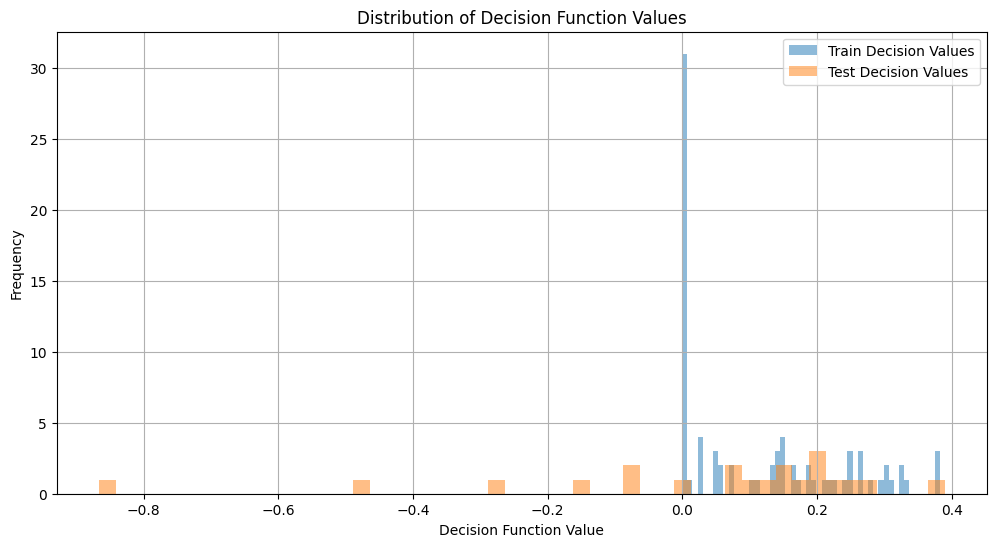

Number of anomalous groups (train): 0 out of 81
Number of anomalous groups (test): 3 out of 21


(OneClassSVM(nu=0.1), StandardScaler(), -0.2)

In [121]:
train_and_evaluate_one_user(crs_df.copy())